In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append("../")

import src.famgen.gen_geno as fgg
import src.famgen.gen_pheno as fgp
import src.xchrom.frreg as frreg
import src.xchrom.optimiz as optimiz

# 1. Make simulation phenotype

In [81]:
# GENOTYPE-related Parameters
num_sample = 1000
num_variant = 10
prop_commom_rare = -1 # only common variant (0 for only rare)

# PHENOTYPE related parameters
dc_type = "FDC"
beta = {"autosome" : np.random.normal(0, 1, size=num_variant),
        "chrX" : np.random.normal(0, 1, size=num_variant)}
hsqs = {
    "autosome" : 0.5,
    "chrX" : 0.02,
    "fam" : 0.05,
    "po" : 0.05,
    "sib" : 0.1,
}

# OTHER parameters
rel_list = ["father_son", "mother_son", "father_daughter", "mother_daughter", 
            "son_son", "son_daughter", "daughter_daughter"]
pos = ["father_son", "mother_son", "father_daughter", "mother_daughter"]
sibs = ["son_son", "son_daughter", "daughter_daughter"]
males = ["father", "son", "son1", "son2"]
females = ["mother", "daughter", "daughter1", "daughter2"]

In [82]:
GenGeno = fgg.FamGenoSimul(num_variant, prop_commom_rare)
GenGeno

FamGenoSimul(num_variant=10, prop_common_rare=-1, maf_lim_common=[0.05, 0.95], maf_lim_rare=[0.01, 0.05], num_common=10, num_rare=0)

In [83]:
# genotype-related add-hoc functions
def make_parents_haps(class_FamGenoSimul, num_sample):
    """Generate parent haplotypes.

    This function generates the haplotypes for the father and mother. The haplotypes
    are stored in a dictionary with the keys "father" and "mother". Each parent has
    two keys, "autosome" and "chrX".

    Args:
        class_FamGenoSimul (class): The FamGenoSimul class instance.
        num_sample (int): The number of samples to generate.

    Returns:
        dict: A dictionary of the generated parent haplotypes.
    """
    dict_parents = {
        "father" : {
            "autosome" : None,
            "chrX" : None},
        "mother" : {
            "autosome" : None,
            "chrX" : None}
    }

    ## MAKE PARENT's HAPS
    for parent in ["father", "mother"]:
        for chr_type in ["autosome", "chrX"]:
            if (chr_type == "chrX") & (parent == "father"):
                dict_parents[parent][chr_type], _ = class_FamGenoSimul.generate_parent_haplotype(num_sample=num_sample, chr_type="haploid")
            else:
                dict_parents[parent][chr_type], _ = class_FamGenoSimul.generate_parent_haplotype(num_sample=num_sample, chr_type="diploid")
    
    return dict_parents

def make_offspring_haps(class_FamGenoSimul, dict_parents, off_type):
    # off_type = "son", "daughter"
    dict_off = {
        "autosome" : None,
        "chrX" : None
    }
    for chr_type in ["autosome", "chrX"]:
        dict_off[chr_type] = class_FamGenoSimul.make_offspring_haplotype(
            haps_mother = dict_parents["mother"][chr_type],
            haps_father = dict_parents["father"][chr_type],
            off_type = off_type,
            chr_type=chr_type
        )
    return dict_off

def make_family_geno(class_FamGenoSimul, num_sample, rel):
    """
    Generate offspring's genotype for the specified relationship type.
    
    Parameters:
    class_FamGenoSimul (class): Class for family simulation.
    num_sample (int): The number of samples to be simulated.
    rel (str): Relationship type. 
        Options: father_son, mother_son, father_daughter, mother_daughter, son_son, son_daughter, daughter_daughter
        
    Returns:
    dict: Dictionary with offspring's genotype for each chromosome type.
    
    """
    parents = ["father", "mother"]
    offs = ["son", "daughter"]
    pos = ["father_son", "mother_son", "father_daughter", "mother_daughter"]
    sibs = ["son_son", "son_daughter", "daughter_daughter"]
    
    dict_parents = make_parents_haps(class_FamGenoSimul, num_sample)
    
    ## MAKE OFFSPRING's HAPS ##
    if rel in ["father_son", "mother_son"]:
        dict_off = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="son")
        
    elif rel in ["father_daughter", "mother_daughter"]:
        dict_off = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="daughter")

    elif rel == "son_son":
        dict_off1 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="son")
        dict_off2 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="son")

    elif rel == "son_daughter":
        dict_off1 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="son")
        dict_off2 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="daughter")

    elif rel == "daughter_daughter":
        dict_off1 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="daughter")
        dict_off2 = make_offspring_haps(class_FamGenoSimul, dict_parents, off_type="daughter")

    else: 
        raise Exception("!!")

    # return dict_parents
    dict_rel = {}
    
    if rel in pos:
        for r in rel.split("_"):
            dict_rel[r] = {}
            for chr_type in ["autosome", "chrX"]:
                if r in parents:
                    dict_rel[r][chr_type] = dict_parents[r][chr_type]
                elif r in offs:
                    dict_rel[r][chr_type] = dict_off[chr_type]
    
    elif rel in sibs:
        for i, r in enumerate(rel.split("_")):
            r_new = r + str(i+1)
            dict_rel[r_new] = {}
            for chr_type in ["autosome", "chrX"]:
                if i == 0:
                    dict_rel[r_new][chr_type] = dict_off1[chr_type]
                else:
                    dict_rel[r_new][chr_type] = dict_off2[chr_type]
            
    return dict_rel

In [84]:
# make simulated phenotype and relationship information
df_phenos = pd.DataFrame(columns=["id", "pheno"])
id_idx = 1

for r in rel_list:
    # make genotype for given relationship pairs
    rel_pair = make_family_geno(GenGeno, num_sample, r)

    s_fam = np.random.normal(0, 1, num_sample) # familial-common shared env
    s_relspec = np.random.normal(0, 1, num_sample) # s_po for po, s_sib for sib
    
    pheno_r = {}
    comps = ["autosome", "chrX", "fam", "po"] if r in pos else ["autosome", "chrX", "fam", "sib"]
    for ii, rr in enumerate(rel_pair.keys()):
        pheno = np.zeros(num_sample)

        haps = rel_pair[rr]
        hsq_sum = 0

        # phenotypical value of each variance component
        for comp in comps:
            if comp == "autosome":
                pheno_comp = fgp.make_pheno(hsqs[comp], haps[comp], beta[comp])
                
            elif comp == "chrX":
                if rr in males:
                    pheno_comp = fgp.make_pheno(hsqs[comp], haps[comp], beta[comp])
                else:
                    pheno_comp = fgp.make_pheno(hsqs[comp], haps[comp], beta[comp], dc_type=dc_type)
            
            elif comp == "fam":
                pheno_comp = fgp.set_var(hsqs[comp], s_fam)
            
            else:
                pheno_comp = fgp.set_var(hsqs[comp], s_fam)
            
            pheno += pheno_comp
            hsq_sum += hsqs[comp]
        
        # individual-specific environemntal effect
        e = np.random.normal(0, 1, num_sample)
        var_e = 1 - hsq_sum
        e = fgp.set_var(var_e, e)
        pheno += e

        # make phenotype file
        id_idx_start = id_idx
        id_idx_end = id_idx_start + len(pheno)
        if ii == 0:
            id_m1 = np.arange(id_idx_start, id_idx_end)
            id_m = id_m1
        else:
            id_m2 = np.arange(id_idx_start, id_idx_end)
            id_m = id_m2
        id_idx = id_idx_end
        df_phenos = pd.concat([df_phenos, pd.DataFrame({"id": id_m,"pheno": pheno})], ignore_index=True)
    
    # make relationship file
    df_relation = pd.DataFrame({list(rel_pair.keys())[0]: id_m1, 
                                list(rel_pair.keys())[1]: id_m2})
    df_relation.to_csv(f"./test_data/{r}.relation", sep='\t', index=False)

# save phenotype
df_phenos[["id", "id", "pheno"]].to_csv("./test_data/simul.phen", sep='\t', index=False)

# 2. Do X-CHROM

In [85]:
import src.xchrom.XCHROM as XCHROM
import seaborn as sns

In [86]:
pheno_fn = "./test_data/simul.phen"

# Relation pair sets (fam, same-sex, sibling, ...)
# R = ["father_son", "father_daughter", "mother_son", "mother_daughter", "son_son", "son_daughter", "daughter_daughter"]
R = ["father_son", "mother_daughter", "son_son", "daughter_daughter"]

rel_fn = {}
for r in R:
    rel_fn[r] = f"./test_data/{r}.relation"

In [87]:
# at once
MODEL = XCHROM.XCHROM()
res_optim, res_frreg = MODEL.estimate_x(rel_fn, pheno_fn, num_boots=1000)

<AxesSubplot:xlabel='r', ylabel='coefficient'>

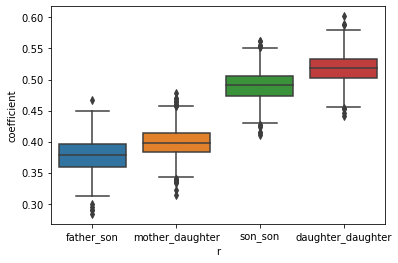

In [88]:
# plot FR-reg
sns.boxplot(
    data = res_frreg,
    x = "r", y = "coefficient",
)

In [89]:
pd.DataFrame(res_optim.mean()).T

,n_boot,a,xMale,xFemale,mPO,func_val
0,499.5,0.964028,0.013882,0.137055,-0.104664,3.839648e-11
